In [1]:
#####################
#FB and GOOG face recognition combined (most kept from FB and included some ideas from GOOG).
#FB
#Facebook transformer for image classification: https://github.com/facebookresearch/deit/blob/main/models_v2.py
#Go to line 269 for examples for different models with different inputs.
#The paper with details on learning rate, optimizer type etc is: https://arxiv.org/pdf/2012.12877.pdf
#GOOG
#Google transformer for image classification: https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py
#The paper is at the following link: https://arxiv.org/pdf/2010.11929.pdf
#Implementation that generalizes Layer_scale_init_Block and adds ScaledLayers, following Google's idea for ParallelBlock.
#Implementation of attention from the original well known paperȘ Attention is all you need: 
#https://nlp.seas.harvard.edu/2018/04/03/attention.html
#####################
from torch import nn, optim, as_tensor
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.nn.init import *
from torchvision import transforms, utils, datasets, models
import cv2
from PIL import Image
from pdb import set_trace
import time
import copy
from pathlib import Path
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage import io, transform
from tqdm import trange, tqdm
import csv 
import glob 
import dlib
import pandas as pd
import numpy as np
from functools import partial
from collections import OrderedDict

!pip install timm
from timm.models.vision_transformer import Mlp, PatchEmbed , _cfg
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from timm.models.registry import register_model


#Imports inside facenet scripts that need to be loaded here on google colab.
import requests
from requests.adapters import HTTPAdapter
import torch
import hashlib
import shutil
import tempfile
from urllib.request import urlopen, Request

use_cuda=torch.cuda.is_available()
device=torch.device("cuda" if use_cuda else "cpu")
print(device)

#####################
#Global valriables
####################
#The following variable determines how many pictures are fed at once into the NN (this is made for speed). 
#Facebook does 4096.
batches=32   
#The following path points to the folder that contains the images with faces only.
data_dir=r"C:\Users\mihnea.andrei\Work\facial_recognition\faces_images"

def imshow(inp,title=None):
  ############
  #Imshow for tensor
  #############
    inp=inp.numpy().transpose([1,2,0])
    mean=np.array([0.485, 0.456, 0.406])
    std=np.array([0.229, 0.224, 0.225])
    inp=std*inp+mean
    inp=np.clip(inp,0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.0001)

#The following function times the NN.
def timming(since):
    time_elapsed=time.time()-since
    minutes=time_elapsed // 60
    seconds=time_elapsed%60
    return "%d m:%d s"%(minutes,seconds)

cpu


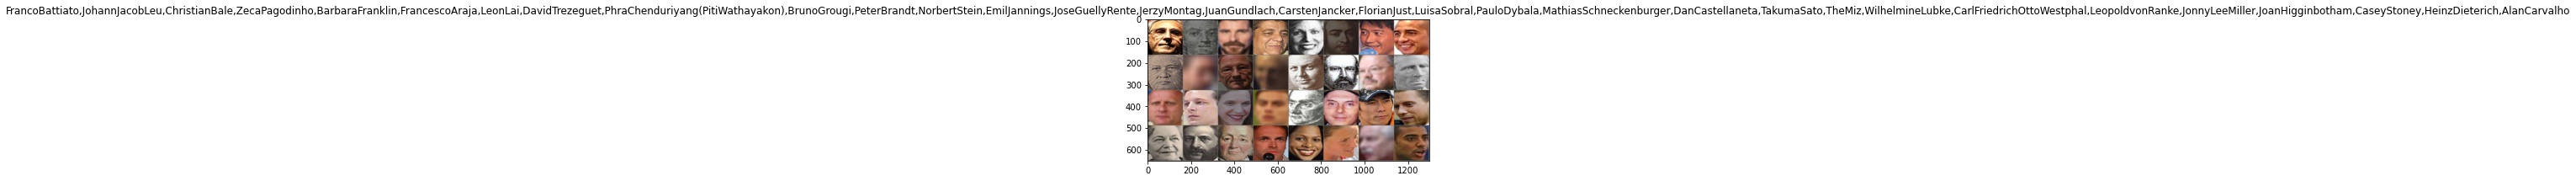

In [2]:
#If you use the MTCNN code that does the random transformations also, you do not need all those transformations again 
#(maybe) except the horizonta flip - the angle from which the picture is taken.
data_transforms={
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),  
        #transforms.ColorJitter(brightness=0.5,contrast=0.5),
        #transforms.GaussianBlur(kernel_size=(5, 9), sigma=(3, 7)),
        #transforms.RandomAdjustSharpness(sharpness_factor=15),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]),
    'eval': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
}
phases=list(data_transforms.keys())
image_datasets={x:datasets.ImageFolder(os.path.join(data_dir,x),data_transforms[x]) for x in list(data_transforms.keys())}
dataloaders={x:torch.utils.data.DataLoader(image_datasets[x],batch_size=batches,shuffle=True) for x in list(data_transforms.keys())}
data_sizes={x:len(image_datasets[x]) for x in list(data_transforms.keys())}
class_names=image_datasets['train'].classes 

inputs, classes = next(iter(dataloaders['train']))
out=utils.make_grid(inputs)
imshow(out,title=",".join([class_names[i] for i in classes.tolist()]))

In [3]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn
class MultiHeadedAttention(nn.Module):
    def __init__(self, dim, num_heads=8, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert dim % num_heads == 0
        # We assume d_v always equals d_k
        self.d_k = dim // num_heads
        self.h = num_heads
        self.linears = clones(nn.Linear(dim, dim), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)
#LayerScale from Google
class LayerScale(nn.Module):
    def __init__(self, dim, init_values=1e-5, inplace=False):
        super().__init__()
        self.inplace = inplace
        self.gamma = nn.Parameter(init_values * torch.ones(dim))

    def forward(self, x):
        return x.mul_(self.gamma) if self.inplace else x * self.gamma

In [4]:
#Original Block class from FB to which I try to add the extra layers that Google has
#Can be passed to block_layers parameter in main class.
class Block(nn.Module):
    # taken from https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py
    def __init__(self, dim, num_heads, mlp_ratio=4., dropout=0.,drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm,
                 Attention_block = MultiHeadedAttention,Mlp_block=Mlp,init_values=1e-4):
        super().__init__()
        self.norm1 = norm_layer(dim)
        
        self.attn = Attention_block(dim=dim, num_heads=num_heads, dropout=dropout)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        #Below, I add the LayerScale that Google has.
        self.ls1=LayerScale(dim,init_values=init_values) if init_values else nn.Identity()
        self.drop_path1 = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp_block(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=dropout)
        #Below I add another LayerScale that Google has
        self.ls2=LayerScale(dim,init_values=init_values) if init_values else nn.Identity()
        self.drop_path2 = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        

    def forward(self, x):
        x = x + self.drop_path1(self.ls1(self.attn(self.norm1(x),self.norm1(x),self.norm1(x))))
        x = x + self.drop_path2(self.ls2(self.mlp(self.norm2(x))))
        return x 

In [5]:
#Take class from below from FB     
#Can be passed to block_layers parameter in main class.
class Layer_scale_init_Block(nn.Module):
    # taken from https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py
    # with slight modifications
    def __init__(self, dim, num_heads, mlp_ratio=4., dropout=0.,drop_path=0., act_layer=nn.GELU, 
                 norm_layer=nn.LayerNorm,Attention_block = MultiHeadedAttention,Mlp_block=Mlp,init_values=1e-4):
        super().__init__()
        #self.norm1 = norm_layer(dim)
        #self.norm12 = norm_layer(dim)
        #self.norm13 = norm_layer(dim)
        self.attn = Attention_block(dim=dim, num_heads=num_heads, dropout=dropout)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp_block(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=dropout)
        self.gamma_1 = nn.Parameter(init_values * torch.ones((dim)),requires_grad=True)
        self.gamma_2 = nn.Parameter(init_values * torch.ones((dim)),requires_grad=True)

    def forward(self, x):
        x = x + self.drop_path(self.gamma_1 * self.attn(x,x,x))
        x = x + self.drop_path(self.gamma_2 * self.mlp(self.norm2(x)))
        return x

In [6]:
###################1#########################
#Can be passed to block_layers parameter in main class.
#Implementation that generalizes Layer_scale_init_Block following Google's idea for ParallelBlock.
#############################################
class ParallelLayer_scale_init_Block(nn.Module):
    def __init__(self,dim,num_heads,mlp_ratio=4,dropout=0,drop_path=0,act_layer=nn.GELU,norm_layer=nn.LayerNorm,
                 Attention_block=MultiHeadedAttention,Mlp_block=Mlp,init_values=10**(-4),num_parallel=2):
        super().__init__()
        self.num_parallel=num_parallel
        self.attns=nn.ModuleList()
        self.ffns=nn.ModuleList()
        
        self.norm1=norm_layer(dim)
        #self.norm2=norm_layer(dim)
        #self.norm3=norm_layer(dim)
        
        #####################3
        #do not know how to multiply by gammas since those are just compositions of functions basically.
        #hopefully it does not matter since gammas are parameters and maybe it will be better if num_parameters>2
        #could add LayerScale to both attention and forward feed.
        ############################
        mlp_hidden_dim = int(dim * mlp_ratio)
        for _ in range(num_parallel):
            self.attns.append(nn.Sequential(OrderedDict([
                ("norm",norm_layer(dim)),
                ("attn",Attention_block(dim,num_heads=num_heads,dropout=dropout)),
                ("ls",LayerScale(dim,init_values=init_values) if init_values else nn.Identity()),
                ("drop_path",DropPath(drop_path) if drop_path>0 else nn.Identity())
            ])))
            self.ffns.append(nn.Sequential(OrderedDict([
                ("norm",norm_layer(dim)),
                ("mlp",Mlp_block(in_features=dim,hidden_features=mlp_hidden_dim,act_layer=act_layer,drop=dropout)),
                ("ls",LayerScale(dim,init_values=init_values) if init_values else nn.Identity()),
                ("drop_path",DropPath(drop_path) if drop_path>0 else nn.Identity())
            ])))
    
    def forward(self,x):
        s=0
        for attn in self.attns:
            counter=0
            for f in attn:
                if counter!=1:
                    x=f(x)
                else:
                    x=f(self.norm1(x),self.norm1(x),self.norm1(x))
                counter+=1
            s+=x
        x=x+torch.stack([ffn(x) for ffn in self.ffns]).sum(dim=0)
        return x

In [12]:
#####################2##########################
#Use the generalized implementation that Google has for FB's Block_paralx2 (num_parallel=2 here for FB's implementation).
#Can be passed to block_layers parameter in main class.
################################################
class ParallelBlock(nn.Module):
    def __init__(self,dim,num_heads,num_parallel=4,mlp_ratio=4,init_values=10**(-4),dropout=0,drop_path=0,act_layer=nn.GELU,
                 norm_layer=nn.LayerNorm,Attention_block=MultiHeadedAttention,Mlp_block=Mlp):
        super().__init__()
        self.num_parallel=num_parallel
        self.attns=nn.ModuleList()
        self.ffns=nn.ModuleList()
        
        self.norm1=norm_layer(dim)
        self.norm2=norm_layer(dim)
        self.norm3=norm_layer(dim)
        for _ in range(num_parallel):
            self.attns.append(nn.Sequential(OrderedDict([
                ("norm",norm_layer(dim)),
                ("attn",Attention_block(dim,num_heads=num_heads,dropout=dropout)),
                ("ls",LayerScale(dim,init_values=init_values) if init_values else nn.Identity()),
                ("drop_path",DropPath(drop_path) if drop_path>0 else nn.Identity()) 
            ])))
            self.ffns.append(nn.Sequential(OrderedDict([
                ("norm",norm_layer(dim)),
                ("mlp",Mlp(dim,hidden_features=int(dim*mlp_ratio),act_layer=act_layer,drop=dropout)),
                ("ls",LayerScale(dim,init_values=init_values) if init_values else nn.Identity()),
                ("drop_path", DropPath(drop_path) if drop_path>0 else nn.Identity())
            ])))
    def forward(self,x):
        s=0
        for attn in self.attns:
            counter=0
            for f in attn:
                if counter!=1:
                    x=f(x)
                else:
                    x=f(self.norm1(x),self.norm2(x),self.norm3(x))
                counter+=1
            s+=x
        x=x+torch.stack([ffn(x) for ffn in self.ffns]).sum(dim=0)
        return x

In [13]:
#Copy class from below from FB
class hMLP_stem(nn.Module):
    """ hMLP_stem: https://arxiv.org/pdf/2203.09795.pdf
    taken from https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py
    with slight modifications
    """
    def __init__(self, img_size=160,  patch_size=16, in_chans=3, embed_dim=768,norm_layer=nn.SyncBatchNorm):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0])
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.proj = torch.nn.Sequential(*[nn.Conv2d(in_chans, embed_dim//4, kernel_size=4, stride=4),
                                          norm_layer(embed_dim//4),
                                          nn.GELU(),
                                          nn.Conv2d(embed_dim//4, embed_dim//4, kernel_size=2, stride=2),
                                          norm_layer(embed_dim//4),
                                          nn.GELU(),
                                          nn.Conv2d(embed_dim//4, embed_dim, kernel_size=2, stride=2),
                                          norm_layer(embed_dim),
                                         ])
        

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x

In [14]:
#Copy class from below from FB
class vit_models(nn.Module):
    """ Vision Transformer with LayerScale (https://arxiv.org/abs/2103.17239) support
    taken from https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py
    with slight modifications
    """
    def __init__(self, img_size=160,  patch_size=16, in_chans=3, num_classes=1000, embed_dim=768, depth=12,
                 num_heads=12, mlp_ratio=4., drop_rate=0.,
                 drop_path_rate=0., norm_layer=nn.LayerNorm, global_pool=None,
                 block_layers = Block,
                 Patch_layer=PatchEmbed,act_layer=nn.GELU,
                 Attention_block = MultiHeadedAttention, Mlp_block=Mlp,
                dpr_constant=True,init_scale=1e-4,
                mlp_ratio_clstk = 4.0):
        super().__init__()
        
        self.dropout_rate = drop_rate

            
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim

        self.patch_embed = Patch_layer(
                img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))

        dpr = [drop_path_rate for i in range(depth)]
        self.blocks = nn.ModuleList([
            block_layers(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio,
                dropout=0.0, drop_path=dpr[i], norm_layer=norm_layer,
                act_layer=act_layer,Attention_block=Attention_block,Mlp_block=Mlp_block,init_values=init_scale)
            for i in range(depth)])
        

        
            
        self.norm = norm_layer(embed_dim)

        self.feature_info = [dict(num_chs=embed_dim, reduction=0, module='head')]
        self.head = nn.Linear(embed_dim, num_classes) if num_classes > 0 else nn.Identity()

        trunc_normal_(self.pos_embed, std=.02)
        trunc_normal_(self.cls_token, std=.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed', 'cls_token'}

    def get_classifier(self):
        return self.head
    
    def get_num_layers(self):
        return len(self.blocks)
    
    def reset_classifier(self, num_classes, global_pool=''):
        self.num_classes = num_classes
        self.head = nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()

    def forward_features(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)

        cls_tokens = self.cls_token.expand(B, -1, -1)
        
        x = x + self.pos_embed
        
        x = torch.cat((cls_tokens, x), dim=1)
            
        for i , blk in enumerate(self.blocks):
            x = blk(x)
            
        x = self.norm(x)
        return x[:, 0]

    def forward(self, x):

        x = self.forward_features(x)
        
        if self.dropout_rate:
            x = F.dropout(x, p=float(self.dropout_rate), training=self.training)
        x = self.head(x)
        
        return x

In [15]:
#The below number is 160 because the faces extracted by MTCNN are 160x160.
img_size=160
#The number of names that the model will see (population of romania over 14).
num_classes=data_sizes["train"]
#Variables inside the network. Please check examples that start at line 271 here: 
#https://github.com/facebookresearch/deit/blob/main/models_v2.py
embed_dim=192
depth=12
num_heads=3
mlp_ratio=4

model_fit=vit_models(num_classes=num_classes,img_size=img_size,patch_size=batches,
                     embed_dim=embed_dim,depth=depth,num_heads=num_heads,mlp_ratio=mlp_ratio,
                    norm_layer=partial(nn.LayerNorm,eps=10**(-6)),
                    block_layers=ParallelBlock).to(device)

num_epochs=25
lr=3*10**(-3)
weight_decay=0.01
criterion=nn.CrossEntropyLoss()
#Facebook does AdamW. Please see paper.
#optimizer=optim.SGD(model_fit.parameters(),lr=10**(-2),momentum=0.9)
optimizer=torch.optim.AdamW(model_fit.parameters(),lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=weight_decay)
#lr_decay=lr_scheduler.StepLR(optimizer,step_size=7,gamma=0.1)
lr_decay=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=num_epochs)

In [16]:
best_model_weights=copy.deepcopy(model_fit.state_dict())
best_acc=0
since=time.time()
printing_iter=10**(1)

all_train_losses=[]
all_train_accs=[]
all_eval_losses=[]
all_eval_accs=[]
best_eval_acc=0

for epoch in range(num_epochs):
    print("-"*100)
    print("Training for epoch %d/%d started"%(epoch+1,num_epochs))
    print("-"*100)
    
    train_losses=[]
    train_accs=[]
    counter=0

    for x, label in dataloaders["train"]:
        x=x.to(device)
        label=label.to(device)
        
        optimizer.zero_grad()
        
        output=model_fit(x)
        loss=criterion(output,label)
        
        output=torch.exp(output)
        _, pred=output.topk(1,dim=1)
        
        loss.backward()
        optimizer.step()
        lr_decay.step()
        
        last_loss=loss.item()
        train_losses.append(last_loss) 
        all_train_losses.append(last_loss)
        pred=pred.cpu()
        label=label.cpu()
        current_acc=100*torch.sum(pred==label.data).double()/batches
        train_accs.append(current_acc)
        all_train_accs.append(current_acc)
        counter+=1

        if counter%printing_iter==0:
            print("Train completion:%.2f%%, time:%s, avg loss: %.2f, avg acc:%.4f%%, last loss: %.2f"
                  %(100*counter*batches/data_sizes["train"],timming(since),np.mean(train_losses),
                    np.mean(train_accs),last_loss))
    
    training_avg_loss=np.mean(train_losses)
    print("-"*100)
    print("Eval for epoch %d/%d started"%(epoch+1,num_epochs))
    print("-"*100)
    
    eval_losses=[]
    eval_accs=[]
    counter=0
    
    with torch.no_grad():
        for x, label in dataloaders["eval"]:
            x=x.to(device)
            label=label.to(device)
            
            output=model_fit(x)
            loss=criterion(output,label)
            
            output=torch.exp(output)
            _, pred=output.topk(1,dim=1)
            
            
            last_loss=loss.item()
            eval_losses.append(last_loss)
            all_eval_losses.append(last_loss)
            pred=pred.cpu()
            label=label.cpu()
            current_acc=100*torch.sum(pred==label.data).double()/batches
            eval_accs.append(current_acc)
            all_eval_accs.append(current_acc)
            counter+=1
            
            if counter%printing_iter==0:
                print("Eval completion:%.2f%%, time:%s, avg loss: %.2f, avg acc:%.4f%%, last loss: %.2f"
                      %(100*counter*batches/data_sizes["eval"],timming(since),np.mean(eval_losses),
                        np.mean(eval_accs),last_loss))
            
    eval_avg_loss=np.mean(eval_losses)
    if np.mean(eval_accs)>best_eval_acc:
        best_eval_acc=np.mean(eval_accs)
        best_model_wts = copy.deepcopy(model_fit.state_dict())
    
    print("-"*100)
    print("Completed epoch %d/%d in %s, avg train loss: %.2f, avg train acc: %.4f%%, avg eval loss: %.2f, avg eval acc: %.4f"%
          (epoch+1,num_epochs,timming(since),training_avg_loss,np.mean(train_accs),eval_avg_loss,np.mean(eval_accs)))
    print("-"*100)

----------------------------------------------------------------------------------------------------
Training for epoch 1/25 started
----------------------------------------------------------------------------------------------------
Train completion:0.13%, time:0 m:17 s, avg loss: 12.41, avg acc:0.0000%, last loss: 12.43
Train completion:0.26%, time:0 m:38 s, avg loss: 12.40, avg acc:0.0000%, last loss: 12.44
Train completion:0.40%, time:1 m:0 s, avg loss: 12.40, avg acc:0.0000%, last loss: 12.31
Train completion:0.53%, time:1 m:21 s, avg loss: 12.40, avg acc:0.0000%, last loss: 12.34
Train completion:0.66%, time:1 m:44 s, avg loss: 12.40, avg acc:0.0000%, last loss: 12.34
Train completion:0.79%, time:2 m:13 s, avg loss: 12.40, avg acc:0.0000%, last loss: 12.45
Train completion:0.92%, time:2 m:45 s, avg loss: 12.39, avg acc:0.0000%, last loss: 12.34
Train completion:1.06%, time:3 m:16 s, avg loss: 12.38, avg acc:0.0000%, last loss: 12.38
Train completion:1.19%, time:3 m:47 s, avg loss

Train completion:11.75%, time:48 m:32 s, avg loss: 11.87, avg acc:0.2247%, last loss: 11.53
Train completion:11.88%, time:49 m:5 s, avg loss: 11.86, avg acc:0.2222%, last loss: 11.40
Train completion:12.01%, time:49 m:39 s, avg loss: 11.86, avg acc:0.2198%, last loss: 11.29
Train completion:12.14%, time:50 m:12 s, avg loss: 11.85, avg acc:0.2174%, last loss: 11.10
Train completion:12.28%, time:50 m:45 s, avg loss: 11.85, avg acc:0.2151%, last loss: 11.14
Train completion:12.41%, time:51 m:18 s, avg loss: 11.84, avg acc:0.2128%, last loss: 11.33
Train completion:12.54%, time:51 m:51 s, avg loss: 11.84, avg acc:0.2105%, last loss: 11.59
Train completion:12.67%, time:52 m:25 s, avg loss: 11.83, avg acc:0.2083%, last loss: 11.18
Train completion:12.80%, time:52 m:59 s, avg loss: 11.83, avg acc:0.2062%, last loss: 11.50
Train completion:12.94%, time:53 m:33 s, avg loss: 11.82, avg acc:0.2041%, last loss: 11.46
Train completion:13.07%, time:54 m:6 s, avg loss: 11.82, avg acc:0.2020%, last lo

Train completion:23.63%, time:102 m:22 s, avg loss: 11.45, avg acc:0.1117%, last loss: 11.07
Train completion:23.76%, time:102 m:59 s, avg loss: 11.45, avg acc:0.1111%, last loss: 10.85
Train completion:23.89%, time:103 m:36 s, avg loss: 11.44, avg acc:0.1105%, last loss: 10.91
Train completion:24.02%, time:104 m:13 s, avg loss: 11.44, avg acc:0.1099%, last loss: 10.66
Train completion:24.16%, time:104 m:50 s, avg loss: 11.44, avg acc:0.1093%, last loss: 10.91
Train completion:24.29%, time:105 m:26 s, avg loss: 11.43, avg acc:0.1087%, last loss: 10.97
Train completion:24.42%, time:106 m:5 s, avg loss: 11.43, avg acc:0.1081%, last loss: 10.34
Train completion:24.55%, time:106 m:41 s, avg loss: 11.43, avg acc:0.1075%, last loss: 10.57
Train completion:24.68%, time:107 m:16 s, avg loss: 11.42, avg acc:0.1070%, last loss: 10.79
Train completion:24.82%, time:107 m:53 s, avg loss: 11.42, avg acc:0.1064%, last loss: 10.86
Train completion:24.95%, time:108 m:28 s, avg loss: 11.42, avg acc:0.10

Train completion:35.38%, time:158 m:16 s, avg loss: 11.18, avg acc:0.0746%, last loss: 10.88
Train completion:35.51%, time:158 m:54 s, avg loss: 11.18, avg acc:0.0743%, last loss: 10.45
Train completion:35.64%, time:159 m:31 s, avg loss: 11.17, avg acc:0.0741%, last loss: 10.55
Train completion:35.77%, time:160 m:7 s, avg loss: 11.17, avg acc:0.0738%, last loss: 10.24
Train completion:35.90%, time:160 m:43 s, avg loss: 11.17, avg acc:0.0735%, last loss: 10.39
Train completion:36.04%, time:161 m:19 s, avg loss: 11.17, avg acc:0.0733%, last loss: 10.55
Train completion:36.17%, time:161 m:56 s, avg loss: 11.16, avg acc:0.0730%, last loss: 10.48
Train completion:36.30%, time:162 m:32 s, avg loss: 11.16, avg acc:0.0727%, last loss: 10.68
Train completion:36.43%, time:163 m:8 s, avg loss: 11.16, avg acc:0.0725%, last loss: 10.76
Train completion:36.56%, time:163 m:44 s, avg loss: 11.16, avg acc:0.0722%, last loss: 10.61
Train completion:36.70%, time:164 m:20 s, avg loss: 11.15, avg acc:0.071

Train completion:47.13%, time:220 m:22 s, avg loss: 10.99, avg acc:0.0840%, last loss: 10.23
Train completion:47.26%, time:221 m:8 s, avg loss: 10.99, avg acc:0.0838%, last loss: 10.51
Train completion:47.39%, time:221 m:54 s, avg loss: 10.99, avg acc:0.0836%, last loss: 10.54
Train completion:47.52%, time:222 m:39 s, avg loss: 10.99, avg acc:0.0833%, last loss: 10.32
Train completion:47.65%, time:223 m:22 s, avg loss: 10.99, avg acc:0.0831%, last loss: 10.43
Train completion:47.79%, time:224 m:6 s, avg loss: 10.98, avg acc:0.0829%, last loss: 10.43
Train completion:47.92%, time:224 m:51 s, avg loss: 10.98, avg acc:0.0826%, last loss: 10.43
Train completion:48.05%, time:225 m:36 s, avg loss: 10.98, avg acc:0.0824%, last loss: 10.23
Train completion:48.18%, time:226 m:20 s, avg loss: 10.98, avg acc:0.0822%, last loss: 10.33
Train completion:48.31%, time:227 m:3 s, avg loss: 10.98, avg acc:0.0820%, last loss: 10.26
Train completion:48.45%, time:227 m:47 s, avg loss: 10.98, avg acc:0.0817

Train completion:58.87%, time:284 m:18 s, avg loss: 10.86, avg acc:0.0897%, last loss: 10.35
Train completion:59.01%, time:285 m:1 s, avg loss: 10.86, avg acc:0.0895%, last loss: 10.27
Train completion:59.14%, time:285 m:46 s, avg loss: 10.86, avg acc:0.0893%, last loss: 10.54
Train completion:59.27%, time:286 m:30 s, avg loss: 10.86, avg acc:0.0891%, last loss: 10.39
Train completion:59.40%, time:287 m:13 s, avg loss: 10.86, avg acc:0.0889%, last loss: 10.46
Train completion:59.53%, time:287 m:59 s, avg loss: 10.86, avg acc:0.0887%, last loss: 10.50
Train completion:59.67%, time:288 m:47 s, avg loss: 10.85, avg acc:0.0885%, last loss: 10.23
Train completion:59.80%, time:289 m:33 s, avg loss: 10.85, avg acc:0.0883%, last loss: 10.34
Train completion:59.93%, time:290 m:23 s, avg loss: 10.85, avg acc:0.0881%, last loss: 10.30
Train completion:60.06%, time:291 m:15 s, avg loss: 10.85, avg acc:0.0879%, last loss: 10.32
Train completion:60.19%, time:292 m:1 s, avg loss: 10.85, avg acc:0.109

Train completion:70.62%, time:356 m:2 s, avg loss: 10.77, avg acc:0.1121%, last loss: 10.08
Train completion:70.75%, time:356 m:50 s, avg loss: 10.77, avg acc:0.1119%, last loss: 10.41
Train completion:70.89%, time:357 m:39 s, avg loss: 10.77, avg acc:0.1117%, last loss: 10.18
Train completion:71.02%, time:358 m:26 s, avg loss: 10.77, avg acc:0.1115%, last loss: 10.18
Train completion:71.15%, time:359 m:14 s, avg loss: 10.76, avg acc:0.1113%, last loss: 10.45
Train completion:71.28%, time:359 m:59 s, avg loss: 10.76, avg acc:0.1111%, last loss: 10.20
Train completion:71.41%, time:360 m:45 s, avg loss: 10.76, avg acc:0.1109%, last loss: 10.14
Train completion:71.55%, time:361 m:31 s, avg loss: 10.76, avg acc:0.1107%, last loss: 10.23
Train completion:71.68%, time:362 m:18 s, avg loss: 10.76, avg acc:0.1105%, last loss: 10.26
Train completion:71.81%, time:363 m:4 s, avg loss: 10.76, avg acc:0.1103%, last loss: 10.22
Train completion:71.94%, time:363 m:49 s, avg loss: 10.76, avg acc:0.110

Train completion:82.37%, time:424 m:14 s, avg loss: 10.70, avg acc:0.0962%, last loss: 10.43
Train completion:82.50%, time:425 m:1 s, avg loss: 10.70, avg acc:0.0960%, last loss: 10.25
Train completion:82.63%, time:425 m:49 s, avg loss: 10.70, avg acc:0.0958%, last loss: 10.23
Train completion:82.77%, time:426 m:37 s, avg loss: 10.70, avg acc:0.0957%, last loss: 10.30
Train completion:82.90%, time:427 m:26 s, avg loss: 10.69, avg acc:0.0955%, last loss: 10.39
Train completion:83.03%, time:428 m:13 s, avg loss: 10.69, avg acc:0.0954%, last loss: 10.20
Train completion:83.16%, time:429 m:1 s, avg loss: 10.69, avg acc:0.0952%, last loss: 10.14
Train completion:83.29%, time:429 m:48 s, avg loss: 10.69, avg acc:0.0951%, last loss: 10.20
Train completion:83.43%, time:430 m:36 s, avg loss: 10.69, avg acc:0.0949%, last loss: 10.40
Train completion:83.56%, time:431 m:22 s, avg loss: 10.69, avg acc:0.0948%, last loss: 10.16
Train completion:83.69%, time:432 m:10 s, avg loss: 10.69, avg acc:0.094

Train completion:94.12%, time:491 m:21 s, avg loss: 10.64, avg acc:0.0982%, last loss: 10.20
Train completion:94.25%, time:492 m:3 s, avg loss: 10.64, avg acc:0.0980%, last loss: 10.20
Train completion:94.38%, time:492 m:47 s, avg loss: 10.64, avg acc:0.0979%, last loss: 10.40
Train completion:94.51%, time:493 m:30 s, avg loss: 10.64, avg acc:0.0978%, last loss: 10.23
Train completion:94.65%, time:494 m:16 s, avg loss: 10.64, avg acc:0.0976%, last loss: 10.31
Train completion:94.78%, time:495 m:1 s, avg loss: 10.64, avg acc:0.0975%, last loss: 10.25
Train completion:94.91%, time:495 m:46 s, avg loss: 10.64, avg acc:0.0974%, last loss: 10.41
Train completion:95.04%, time:496 m:31 s, avg loss: 10.64, avg acc:0.0972%, last loss: 10.30
Train completion:95.17%, time:497 m:15 s, avg loss: 10.64, avg acc:0.0971%, last loss: 10.28
Train completion:95.31%, time:498 m:0 s, avg loss: 10.64, avg acc:0.0970%, last loss: 10.13
Train completion:95.44%, time:498 m:45 s, avg loss: 10.64, avg acc:0.0968

Eval completion:59.19%, time:529 m:38 s, avg loss: 10.26, avg acc:0.2326%, last loss: 10.28
Eval completion:60.57%, time:529 m:44 s, avg loss: 10.26, avg acc:0.2273%, last loss: 10.17
Eval completion:61.94%, time:529 m:50 s, avg loss: 10.26, avg acc:0.2222%, last loss: 10.22
Eval completion:63.32%, time:529 m:56 s, avg loss: 10.26, avg acc:0.2174%, last loss: 10.28
Eval completion:64.70%, time:530 m:2 s, avg loss: 10.26, avg acc:0.2128%, last loss: 10.42
Eval completion:66.07%, time:530 m:7 s, avg loss: 10.26, avg acc:0.2083%, last loss: 10.15
Eval completion:67.45%, time:530 m:14 s, avg loss: 10.26, avg acc:0.2041%, last loss: 10.15
Eval completion:68.83%, time:530 m:19 s, avg loss: 10.26, avg acc:0.2000%, last loss: 10.45
Eval completion:70.20%, time:530 m:26 s, avg loss: 10.26, avg acc:0.1961%, last loss: 10.15
Eval completion:71.58%, time:530 m:31 s, avg loss: 10.26, avg acc:0.1923%, last loss: 10.18
Eval completion:72.96%, time:530 m:37 s, avg loss: 10.26, avg acc:0.1887%, last lo

Train completion:7.26%, time:576 m:9 s, avg loss: 10.16, avg acc:0.0000%, last loss: 10.17
Train completion:7.39%, time:576 m:58 s, avg loss: 10.16, avg acc:0.0000%, last loss: 10.19
Train completion:7.52%, time:577 m:48 s, avg loss: 10.16, avg acc:0.1754%, last loss: 10.08
Train completion:7.66%, time:578 m:38 s, avg loss: 10.16, avg acc:0.1724%, last loss: 10.15
Train completion:7.79%, time:579 m:27 s, avg loss: 10.16, avg acc:0.1695%, last loss: 10.20
Train completion:7.92%, time:580 m:18 s, avg loss: 10.16, avg acc:0.1667%, last loss: 10.14
Train completion:8.05%, time:581 m:8 s, avg loss: 10.16, avg acc:0.1639%, last loss: 10.19
Train completion:8.18%, time:581 m:56 s, avg loss: 10.16, avg acc:0.1613%, last loss: 10.21
Train completion:8.32%, time:582 m:44 s, avg loss: 10.16, avg acc:0.1587%, last loss: 10.11
Train completion:8.45%, time:583 m:30 s, avg loss: 10.16, avg acc:0.1562%, last loss: 10.17
Train completion:8.58%, time:584 m:16 s, avg loss: 10.16, avg acc:0.1538%, last lo

KeyboardInterrupt: 

In [ ]:
save_model_path=r"C:\Users\mihnea.andrei\Work\facial_recognition\saved_models"
save_file="/ViTm,embedded=%d,depth=%d,num_heads=%d,eval_loss=%.4f,eval_acc=%d%%.pt"%(
    embed_dim,depth,num_heads,np.mean(all_eval_losses),np.mean(all_eval_accs))

torch.save(model_fit,save_model_path+save_file)

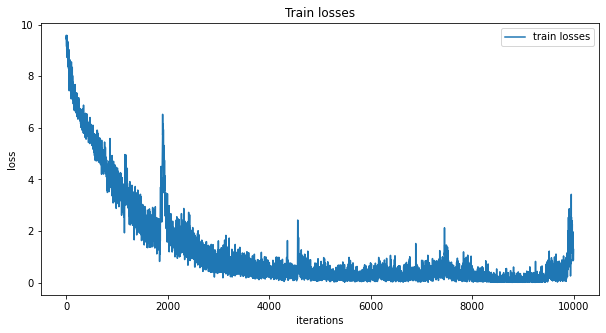

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Train losses")
plt.plot(all_train_losses,label="train losses")
plt.xlabel("iterations")
plt.ylabel("loss")
plt.legend()
plt.show()

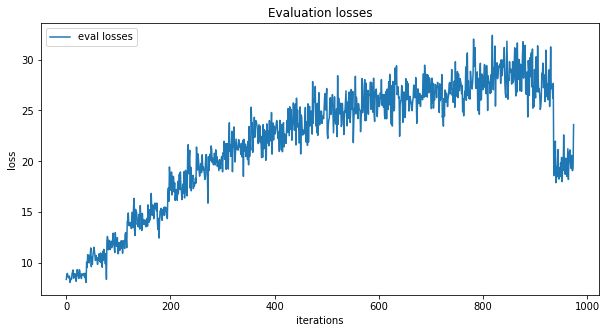

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Evaluation losses")
plt.plot(all_eval_losses,label="eval losses")
plt.xlabel("iterations")
plt.ylabel("loss")
plt.legend()
plt.show()

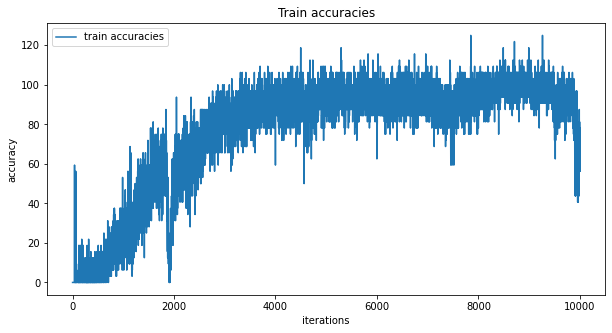

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Train accuracies")
plt.plot(all_train_accs,label="train accuracies")
plt.xlabel("iterations")
plt.ylabel("accuracy")
plt.legend()
plt.show()

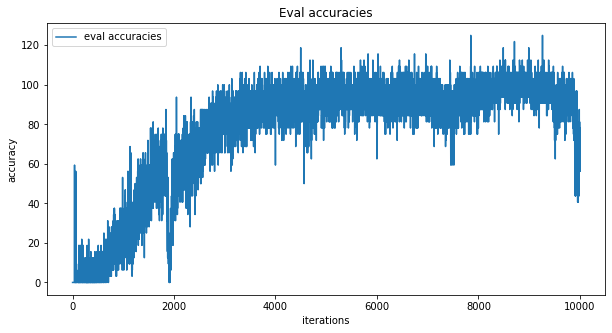

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Eval accuracies")
plt.plot(all_train_accs,label="eval accuracies")
plt.xlabel("iterations")
plt.ylabel("accuracy")
plt.legend()
plt.show()